# IsotonicBinning: Feature Demonstration

This notebook demonstrates the key features of the `IsotonicBinning` class from the binlearn library.

## Key Features Covered:
- Basic binning with monotonic relationships
- Increasing vs decreasing monotonicity
- Working with pandas DataFrames and numpy arrays
- Sklearn pipeline integration
- Parameter serialization and reconstruction
- Edge case handling

## Overview
`IsotonicBinning` creates bins that preserve monotonic relationships between features and targets, making it ideal for:
- **Risk scoring models** (age → risk, income → creditworthiness)
- **Dose-response relationships** (medication dose → effect)
- **Time-series features** (experience → performance)
- **Regulatory compliance** where monotonicity is required

## 1. Setup and Data Preparation

In [40]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from scipy.stats import pearsonr
from binlearn.methods import IsotonicBinning
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [41]:
# Create sample datasets with monotonic relationships
n_samples = 250

# 1. Increasing monotonic relationship (age → risk score)
age = np.random.uniform(18, 80, n_samples)
risk_score = 0.5 * age + 0.2 * age**0.5 + np.random.normal(0, 5, n_samples)
df_increasing = pd.DataFrame({
    'age': age,
    'income': np.random.uniform(20000, 120000, n_samples),  # Non-monotonic feature
    'risk_score': risk_score
})

# 2. Decreasing monotonic relationship (experience → error_rate)
experience = np.random.uniform(0, 20, n_samples)
error_rate = 50 * np.exp(-0.3 * experience) + np.random.normal(0, 3, n_samples)
df_decreasing = pd.DataFrame({
    'experience_years': experience,
    'training_hours': np.random.uniform(0, 1000, n_samples),  # Non-monotonic feature
    'error_rate': np.maximum(0, error_rate)  # Ensure non-negative
})

# 3. Mixed relationships dataset
x1 = np.random.uniform(0, 10, n_samples)
x2 = np.random.uniform(-5, 5, n_samples)
y_mixed = 2 * x1 + 0.5 * x1**2 - 0.3 * x2**2 + np.random.normal(0, 2, n_samples)
df_mixed = pd.DataFrame({
    'monotonic_feature': x1,
    'non_monotonic_feature': x2,
    'target': y_mixed
})

# 4. NumPy array for basic demonstration
array_data = np.column_stack([age[:100], risk_score[:100]])

print(f"📊 Created datasets:")
print(f"   - Increasing relationship: {df_increasing.shape}")
print(f"   - Decreasing relationship: {df_decreasing.shape}")
print(f"   - Mixed relationships: {df_mixed.shape}")
print(f"   - Array data: {array_data.shape}")

# Check correlations
corr_age_risk = pearsonr(df_increasing['age'], df_increasing['risk_score'])[0]
corr_exp_error = pearsonr(df_decreasing['experience_years'], df_decreasing['error_rate'])[0]
print(f"\n📈 Correlations:")
print(f"   Age vs Risk Score: {corr_age_risk:.3f} (should be positive)")
print(f"   Experience vs Error Rate: {corr_exp_error:.3f} (should be negative)")

📊 Created datasets:
   - Increasing relationship: (250, 3)
   - Decreasing relationship: (250, 3)
   - Mixed relationships: (250, 3)
   - Array data: (100, 2)

📈 Correlations:
   Age vs Risk Score: 0.879 (should be positive)
   Experience vs Error Rate: -0.783 (should be negative)


## 2. Basic Binning Operations

In [42]:
# Basic increasing monotonic binning
print("🎯 Basic IsotonicBinning Demonstration - Increasing")
print("=" * 50)

# Create and fit binner for increasing relationship
binner_inc = IsotonicBinning(
    increasing=True,
    max_bins=6,
    min_samples_per_bin=15,
    guidance_columns=['risk_score']
)
binner_inc.fit(df_increasing)

# Transform data
binned_inc = binner_inc.transform(df_increasing[['age', 'income']])

print(f"📊 Bin edges created:")
for col, edges in binner_inc.bin_edges_.items():
    print(f"   {col}: {len(edges)-1} bins, edges: {np.round(edges, 1)}")

print(f"\n🔢 Binned data shape: {binned_inc.shape}")
print(f"📈 Unique values per feature: {[len(np.unique(binned_inc[:, i])) for i in range(binned_inc.shape[1])]}")

# Show age bin representatives and average risk scores
age_bins = binner_inc.bin_representatives_['age']
print(f"\n📏 Age bin representatives: {np.round(age_bins, 1)}")

# Calculate average risk score per age bin
age_binned = binner_inc.transform(df_increasing)[:, 0]
for i, bin_rep in enumerate(age_bins):
    mask = age_binned == i
    avg_risk = df_increasing.loc[mask, 'risk_score'].mean()
    print(f"   Bin {i} (age ~{bin_rep:.1f}): avg risk = {avg_risk:.2f}")

🎯 Basic IsotonicBinning Demonstration - Increasing
📊 Bin edges created:
   age: 5 bins, edges: [18.3 19.8 23.  26.7 30.3 79.2]
   income: 5 bins, edges: [ 20463.2  25590.2  33974.6  73939.6 113797.1 118996. ]

🔢 Binned data shape: (250, 2)
📈 Unique values per feature: [5, 5]

📏 Age bin representatives: [19.5 23.  26.5 30.  55.9]
   Bin 0 (age ~19.5): avg risk = 10.34
   Bin 1 (age ~23.0): avg risk = 11.09
   Bin 2 (age ~26.5): avg risk = 15.56
   Bin 3 (age ~30.0): avg risk = 15.31
   Bin 4 (age ~55.9): avg risk = 29.38


In [43]:
# Basic decreasing monotonic binning
print("\n📉 IsotonicBinning - Decreasing Relationship")
print("=" * 45)

# Create and fit binner for decreasing relationship
binner_dec = IsotonicBinning(
    increasing=False,  # Decreasing monotonicity
    max_bins=5,
    min_samples_per_bin=20,
    guidance_columns=['error_rate']
)
binner_dec.fit(df_decreasing)

# Transform data
binned_dec = binner_dec.transform(df_decreasing[['experience_years', 'training_hours']])

print(f"📊 Bin edges created:")
for col, edges in binner_dec.bin_edges_.items():
    print(f"   {col}: {len(edges)-1} bins, edges: {np.round(edges, 1)}")

# Show experience bin representatives and average error rates
exp_bins = binner_dec.bin_representatives_['experience_years']
print(f"\n📏 Experience bin representatives: {np.round(exp_bins, 1)}")

# Calculate average error rate per experience bin
exp_binned = binner_dec.transform(df_decreasing)[:, 0]
for i, bin_rep in enumerate(exp_bins):
    mask = exp_binned == i
    avg_error = df_decreasing.loc[mask, 'error_rate'].mean()
    print(f"   Bin {i} (exp ~{bin_rep:.1f}): avg error = {avg_error:.2f}")

# Demonstrate with numpy arrays
print(f"\n🔢 NumPy Array Support:")
binner_array = IsotonicBinning(increasing=True, max_bins=4, guidance_columns=[1])
binner_array.fit(array_data)
binned_array = binner_array.transform(array_data)
print(f"   Array shape: {array_data.shape} → {binned_array.shape}")
print(f"   Unique values: {len(np.unique(binned_array))}")


📉 IsotonicBinning - Decreasing Relationship
📊 Bin edges created:
   experience_years: 4 bins, edges: [ 0.2  0.8  2.1  3.7 20. ]
   training_hours: 4 bins, edges: [  4.9  45.3 119.  401.6 999.4]

📏 Experience bin representatives: [ 0.6  2.   3.7 11.9]
   Bin 0 (exp ~0.6): avg error = 44.46
   Bin 1 (exp ~2.0): avg error = 34.43
   Bin 2 (exp ~3.7): avg error = 20.50
   Bin 3 (exp ~11.9): avg error = 4.31

🔢 NumPy Array Support:
   Array shape: (100, 2) → (100, 1)
   Unique values: 3


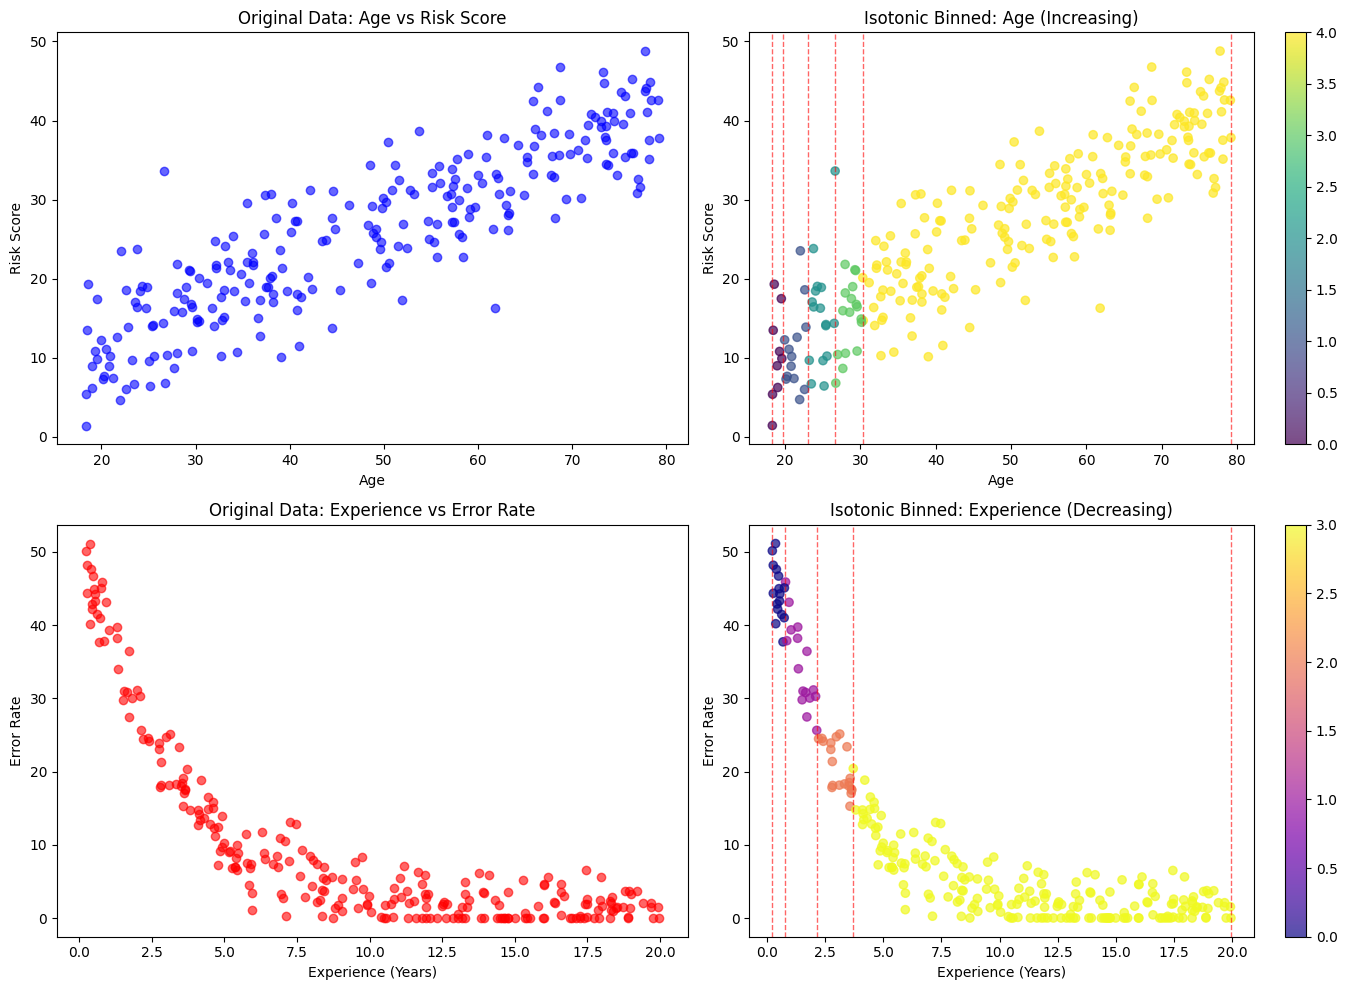

In [44]:
# Visualize isotonic binning results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Original increasing relationship
ax1.scatter(df_increasing['age'], df_increasing['risk_score'], alpha=0.6, color='blue')
ax1.set_title('Original Data: Age vs Risk Score')
ax1.set_xlabel('Age')
ax1.set_ylabel('Risk Score')

# Binned increasing relationship with boundaries
age_binned_vis = binner_inc.transform(df_increasing)[:, 0]
scatter1 = ax2.scatter(df_increasing['age'], df_increasing['risk_score'], 
                      c=age_binned_vis, cmap='viridis', alpha=0.7)

# Add bin boundaries for age
for edge in binner_inc.bin_edges_['age']:
    ax2.axvline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)

ax2.set_title('Isotonic Binned: Age (Increasing)')
ax2.set_xlabel('Age')
ax2.set_ylabel('Risk Score')
plt.colorbar(scatter1, ax=ax2)

# Original decreasing relationship
ax3.scatter(df_decreasing['experience_years'], df_decreasing['error_rate'], 
           alpha=0.6, color='red')
ax3.set_title('Original Data: Experience vs Error Rate')
ax3.set_xlabel('Experience (Years)')
ax3.set_ylabel('Error Rate')

# Binned decreasing relationship
exp_binned_vis = binner_dec.transform(df_decreasing)[:, 0]
scatter2 = ax4.scatter(df_decreasing['experience_years'], df_decreasing['error_rate'],
                      c=exp_binned_vis, cmap='plasma', alpha=0.7)

# Add bin boundaries for experience
for edge in binner_dec.bin_edges_['experience_years']:
    ax4.axvline(edge, linestyle='--', alpha=0.6, color='red', linewidth=1)

ax4.set_title('Isotonic Binned: Experience (Decreasing)')
ax4.set_xlabel('Experience (Years)')
ax4.set_ylabel('Error Rate')
plt.colorbar(scatter2, ax=ax4)

plt.tight_layout()
plt.show()

## 3. Monotonicity Parameter Effects

In [45]:
# Demonstrate parameter effects on binning
print("🔧 Parameter Effects on Isotonic Binning")
print("=" * 45)

# Test different parameter configurations
param_configs = {
    'Conservative': {'max_bins': 4, 'min_samples_per_bin': 30, 'min_change_threshold': 0.05},
    'Moderate': {'max_bins': 6, 'min_samples_per_bin': 15, 'min_change_threshold': 0.02},
    'Aggressive': {'max_bins': 8, 'min_samples_per_bin': 10, 'min_change_threshold': 0.01}
}

results = {}
for config_name, params in param_configs.items():
    print(f"\n🎯 {config_name} Configuration:")
    print(f"   Parameters: {params}")
    
    # Create binner with parameters
    binner = IsotonicBinning(
        increasing=True,
        guidance_columns=['risk_score'],
        **params
    )
    
    # Fit and analyze
    binner.fit(df_increasing)
    
    # Store results
    age_bins = len(binner.bin_edges_['age']) - 1
    income_bins = len(binner.bin_edges_['income']) - 1
    
    results[config_name] = {
        'age_bins': age_bins,
        'income_bins': income_bins,
        'total_bins': age_bins + income_bins
    }
    
    print(f"   Age bins: {age_bins}, Income bins: {income_bins}")
    print(f"   Total bins: {age_bins + income_bins}")

# Compare wrong vs correct monotonicity direction
print(f"\n🔄 Monotonicity Direction Comparison:")
print("=" * 40)

# Correct direction (increasing)
binner_correct = IsotonicBinning(
    increasing=True, max_bins=5, guidance_columns=['risk_score']
)
binner_correct.fit(df_increasing)
age_bins_correct = len(binner_correct.bin_edges_['age']) - 1

# Wrong direction (decreasing)
binner_wrong = IsotonicBinning(
    increasing=False, max_bins=5, guidance_columns=['risk_score']
)
binner_wrong.fit(df_increasing)
age_bins_wrong = len(binner_wrong.bin_edges_['age']) - 1

print(f"Correct direction (increasing=True): {age_bins_correct} age bins")
print(f"Wrong direction (increasing=False): {age_bins_wrong} age bins")
print(f"Note: Wrong direction may create fewer meaningful bins")

🔧 Parameter Effects on Isotonic Binning

🎯 Conservative Configuration:
   Parameters: {'max_bins': 4, 'min_samples_per_bin': 30, 'min_change_threshold': 0.05}
   Age bins: 3, Income bins: 3
   Total bins: 6

🎯 Moderate Configuration:
   Parameters: {'max_bins': 6, 'min_samples_per_bin': 15, 'min_change_threshold': 0.02}
   Age bins: 5, Income bins: 5
   Total bins: 10

🎯 Aggressive Configuration:
   Parameters: {'max_bins': 8, 'min_samples_per_bin': 10, 'min_change_threshold': 0.01}
   Age bins: 7, Income bins: 5
   Total bins: 12

🔄 Monotonicity Direction Comparison:
Correct direction (increasing=True): 4 age bins
Wrong direction (increasing=False): 1 age bins
Note: Wrong direction may create fewer meaningful bins


## 4. Sklearn Pipeline Integration

In [46]:
# Demonstrate pipeline integration
print("🔗 Sklearn Pipeline Integration")
print("=" * 35)

# Split data for regression
X_train, X_test, y_train, y_test = train_test_split(
    df_increasing[['age', 'income']], 
    df_increasing['risk_score'], 
    test_size=0.3, 
    random_state=42
)

# Create pipeline with isotonic binning and regression
pipeline = Pipeline([
    ('binner', IsotonicBinning(
        increasing=True,
        max_bins=6,
        min_samples_per_bin=10
    )),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mse = np.mean((y_pred - y_test)**2)
r2 = 1 - mse / np.var(y_test)

print(f"✅ Pipeline trained successfully")
print(f"📊 Test R² score: {r2:.3f}")
print(f"📊 Test MSE: {mse:.3f}")
print(f"🔢 Features binned: {X_train.shape[1]}")

# Show bin edges from pipeline
binner_from_pipeline = pipeline.named_steps['binner']
print(f"\n📏 Bin edges created:")
for col, edges in binner_from_pipeline.bin_edges_.items():
    print(f"   {col}: {len(edges)-1} bins, range: [{edges[0]:.1f}, {edges[-1]:.1f}]")

# Compare with non-monotonic binning
from binlearn.methods import TreeBinning

pipeline_supervised = Pipeline([
    ('binner', TreeBinning(task_type='regression')),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42))
])

pipeline_supervised.fit(X_train, y_train)
y_pred_supervised = pipeline_supervised.predict(X_test)
mse_supervised = np.mean((y_pred_supervised - y_test)**2)
r2_supervised = 1 - mse_supervised / np.var(y_test)

print(f"\n📈 Comparison with TreeBinning:")
print(f"   Isotonic binning R²: {r2:.3f}")
print(f"   Supervised binning R²: {r2_supervised:.3f}")
print(f"   Difference: {r2 - r2_supervised:+.3f}")

🔗 Sklearn Pipeline Integration
✅ Pipeline trained successfully
📊 Test R² score: 0.286
📊 Test MSE: 74.884
🔢 Features binned: 2

📏 Bin edges created:
   age: 5 bins, range: [18.3, 78.3]
   income: 4 bins, range: [21811.0, 118996.0]

📈 Comparison with TreeBinning:
   Isotonic binning R²: 0.286
   Supervised binning R²: 0.702
   Difference: -0.416


## 5. Parameter Serialization and Reconstruction

In [47]:
# Demonstrate serialization for model persistence
print("💾 Parameter Serialization & Reconstruction")
print("=" * 45)

# Create and fit original binner
original_binner = IsotonicBinning(
    increasing=True,
    max_bins=5,
    min_samples_per_bin=20,
    min_change_threshold=0.02,
    guidance_columns=['risk_score']
)
original_binner.fit(df_increasing)
original_result = original_binner.transform(df_increasing)

# Serialize parameters
params = original_binner.get_params()
print(f"📋 Serialized parameters: {params}")

# Reconstruct binner from parameters
reconstructed_binner = IsotonicBinning(**params)

# Test reconstruction
reconstructed_result = reconstructed_binner.transform(df_increasing)
results_match = np.allclose(original_result, reconstructed_result)

print(f"\n🔍 Reconstruction verification:")
print(f"   ✅ Results identical: {results_match}")
print(f"   📊 Original shape: {original_result.shape}")
print(f"   📊 Reconstructed shape: {reconstructed_result.shape}")

# Test with new data (different age/income ranges)
new_age = np.random.uniform(25, 75, 50)
new_income = np.random.uniform(30000, 100000, 50)
df_new = pd.DataFrame({
    'age': new_age,
    'income': new_income
})

test_result = reconstructed_binner.transform(df_new)
print(f"\n🔄 Transform new data without refitting:")
print(f"   ✅ Success: {test_result.shape}")
print(f"   🔢 Unique bins: {len(np.unique(test_result))}")

# Verify monotonicity is preserved in new data
age_binned_new = test_result[:, 0]
age_order_preserved = all(age_binned_new[i] <= age_binned_new[j] 
                         for i, j in zip(np.argsort(df_new['age'])[:-1], 
                                        np.argsort(df_new['age'])[1:]))
print(f"   📈 Age monotonicity preserved: {age_order_preserved}")

💾 Parameter Serialization & Reconstruction
📋 Serialized parameters: {'max_bins': 5, 'min_samples_per_bin': 20, 'increasing': True, 'y_min': None, 'y_max': None, 'min_change_threshold': 0.02, 'clip': True, 'preserve_dataframe': False, 'guidance_columns': ['risk_score'], 'bin_edges': {'age': [18.313818198465558, 20.467979053305676, 25.14690008449518, 29.857199161558356, 79.18699006923208], 'income': [20463.202300460285, 25833.54625863276, 34217.93866848411, 73939.59910830884, 118996.02323899453]}, 'bin_representatives': {'age': [20.097061252614363, 24.733174162689878, 29.436447125309513, 55.87421858409256], 'income': [26119.046600775182, 33975.024456790634, 72233.64977665433, 114499.47575139166]}, 'class_': 'IsotonicBinning', 'module_': 'binlearn.methods._isotonic_binning'}

🔍 Reconstruction verification:
   ✅ Results identical: True
   📊 Original shape: (250, 2)
   📊 Reconstructed shape: (250, 2)

🔄 Transform new data without refitting:
   ✅ Success: (50, 2)
   🔢 Unique bins: 3
   📈 Age

## 6. Edge Cases and Robustness

In [48]:
# Test edge cases
print("⚠️ Edge Case Testing")
print("=" * 25)

# Create edge case datasets
edge_cases = {
    'No monotonic relationship': {
        'data': pd.DataFrame({
            'random_feature': np.random.uniform(0, 10, 100),
            'random_target': np.random.uniform(0, 10, 100)
        }),
        'features': ['random_feature'],
        'target': 'random_target'
    },
    'Perfect monotonic relationship': {
        'data': pd.DataFrame({
            'x': np.linspace(0, 10, 50),
            'y': np.linspace(0, 10, 50)  # Perfect correlation
        }),
        'features': ['x'],
        'target': 'y'
    },
    'Small dataset': {
        'data': pd.DataFrame({
            'feature': [1.0, 2.0, 3.0, 4.0, 5.0],
            'target': [1.0, 2.5, 3.8, 4.2, 5.1]
        }),
        'features': ['feature'],
        'target': 'target'
    },
    'Constant target': {
        'data': pd.DataFrame({
            'feature': np.random.uniform(0, 10, 50),
            'constant_target': np.full(50, 5.0)
        }),
        'features': ['feature'],
        'target': 'constant_target'
    }
}

for case_name, case_info in edge_cases.items():
    print(f"\n🧪 Testing: {case_name}")
    try:
        binner = IsotonicBinning(
            increasing=True,
            max_bins=4,
            min_samples_per_bin=3,
            guidance_columns=[case_info['target']]
        )
        binner.fit(case_info['data'])
        result = binner.transform(case_info['data'][case_info['features']])
        
        print(f"   ✅ Success: {result.shape}")
        print(f"   📊 Unique bins: {len(np.unique(result))}")
        
        # Show bin edges
        for col, edges in binner.bin_edges_.items():
            print(f"   📏 {col} bins: {len(edges)-1}, range: [{edges[0]:.2f}, {edges[-1]:.2f}]")
        
        # Check correlation for relationship assessment
        feature_data = case_info['data'][case_info['features'][0]]
        target_data = case_info['data'][case_info['target']]
        if len(np.unique(target_data)) > 1:  # Avoid constant target correlation
            corr = pearsonr(feature_data, target_data)[0]
            print(f"   📈 Feature-target correlation: {corr:.3f}")
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")

⚠️ Edge Case Testing

🧪 Testing: No monotonic relationship
   ✅ Success: (100, 1)
   📊 Unique bins: 3
   📏 random_feature bins: 3, range: [0.00, 9.79]
   📈 Feature-target correlation: 0.125

🧪 Testing: Perfect monotonic relationship
   ✅ Success: (50, 1)
   📊 Unique bins: 3
   📏 x bins: 3, range: [0.00, 10.00]
   📈 Feature-target correlation: 1.000

🧪 Testing: Small dataset
   ✅ Success: (5, 1)
   📊 Unique bins: 2
   📏 feature bins: 2, range: [1.00, 5.00]
   📈 Feature-target correlation: 0.979

🧪 Testing: Constant target
   ✅ Success: (50, 1)
   📊 Unique bins: 1
   📏 feature bins: 1, range: [0.08, 9.95]


## 7. Summary and Best Practices

In [49]:
# Summary and recommendations
print("📝 IsotonicBinning Summary")
print("=" * 35)

recommendations = {
    "✅ Best for": [
        "Risk scoring models with known monotonic relationships",
        "Dose-response and time-series feature engineering",
        "Regulatory compliance requiring monotonicity",
        "Age, experience, or tenure-based features"
    ],
    "⚠️ Use with caution": [
        "Features without clear monotonic relationships",
        "Very noisy data where monotonicity is unclear",
        "Small datasets with insufficient samples per bin"
    ],
    "💡 Tips": [
        "Verify monotonic relationship exists before applying",
        "Choose correct increasing/decreasing direction",
        "Use min_samples_per_bin to ensure statistical reliability",
        "Adjust min_change_threshold based on data noise level"
    ]
}

for category, items in recommendations.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")

print(f"\n🎯 Key Features Demonstrated:")
features = [
    "Increasing and decreasing monotonic relationships",
    "Parameter tuning for optimal bin creation",
    "Monotonicity preservation in predictions",
    "Support for pandas DataFrames and numpy arrays",
    "Seamless sklearn pipeline integration",
    "Parameter serialization and model reconstruction",
    "Robust handling of edge cases and relationship validation"
]

for i, feature in enumerate(features, 1):
    print(f"  {i}. {feature}")

print(f"\n✨ IsotonicBinning demonstration complete!")
print(f"\n💡 Remember: Always validate that monotonic relationships")
print(f"    exist in your data before using IsotonicBinning!")

📝 IsotonicBinning Summary

✅ Best for:
  • Risk scoring models with known monotonic relationships
  • Dose-response and time-series feature engineering
  • Regulatory compliance requiring monotonicity
  • Age, experience, or tenure-based features

⚠️ Use with caution:
  • Features without clear monotonic relationships
  • Very noisy data where monotonicity is unclear
  • Small datasets with insufficient samples per bin

💡 Tips:
  • Verify monotonic relationship exists before applying
  • Choose correct increasing/decreasing direction
  • Use min_samples_per_bin to ensure statistical reliability
  • Adjust min_change_threshold based on data noise level

🎯 Key Features Demonstrated:
  1. Increasing and decreasing monotonic relationships
  2. Parameter tuning for optimal bin creation
  3. Monotonicity preservation in predictions
  4. Support for pandas DataFrames and numpy arrays
  5. Seamless sklearn pipeline integration
  6. Parameter serialization and model reconstruction
  7. Robust h